# Evaluation of Clinical Benefit: Week 12 Model

Gaylen Fronk  
June 4, 2024

In [ ]:
study <- "match"
version <- "v6"
y_col_name <- "pp_hybrid_wk12_outcome"


In [ ]:

# packages for script
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Loading required package: lme4
Loading required package: Matrix

Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack

ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

ℹ SHA-1 hash of file is "75cc6f7b855da59c240908bd936834b4da01285b"

In [ ]:

# handle conflicts
options(conflicts.policy = "depends.ok")


In [ ]:
# absolute paths
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_models <- str_c("P:/studydata/match/models/", y_col_name)},
        
        # IOS paths
        Darwin = {
          path_models <- str_c("/Volumes/private/studydata/match/models/", y_col_name)},
        
        # Linux paths
        Linux = {
          path_models <- str_c("~/mnt/private/studydata/match/models/", y_col_name)}
)


In [ ]:
# chunk defaults

options(tibble.width = Inf)
options(tibble.print_max = Inf)


Read in aim 2 dataset

In [ ]:
d <- read_csv(file.path(path_models, 
                        str_c("aim_2_", version, "_", y_col_name, ".csv")),
              show_col_types = FALSE) |> 
  mutate(outcome_rct_wk4_num = if_else(outcome_rct_wk4 == "abstinent", 1, 0),
         outcome_rct_wk12_num = if_else(outcome_rct_wk12 == "abstinent", 1, 0),
         outcome_rct_wk26_num = if_else(outcome_rct_wk26 == "abstinent", 1, 0),
         tx_worst = case_when(
           prob_patch < prob_combo_nrt & prob_patch < prob_varenicline ~ "patch",
           prob_combo_nrt < prob_patch & prob_combo_nrt < prob_varenicline ~ "combo_nrt",
           prob_varenicline < prob_patch & prob_varenicline < prob_combo_nrt ~ "varenicline",
           TRUE ~ NA_character_),
         tx_second = case_when(
           tx_worst == "patch" & tx_best == "varenicline" ~ "combo_nrt",
           tx_worst == "patch" & tx_best == "combo_nrt" ~ "varenicline",
           tx_worst == "varenicline" & tx_best == "patch" ~ "combo_nrt",
           tx_worst == "varenicline" & tx_best == "combo_nrt" ~ "patch",
           tx_worst == "combo_nrt" & tx_best == "varenicline" ~ "patch",
           tx_worst == "combo_nrt" & tx_best == "patch" ~ "varenicline",
           TRUE ~ NA_character_)) |> 
  mutate(tx_rank = case_when(
    tx_rct == tx_best ~ "first",
    tx_rct == tx_second ~ "second",
    tx_rct == tx_worst ~ "third",
    TRUE ~ NA_character_)) |> 
  select(subid, starts_with("tx_"), starts_with("prob_"),
         outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num) |> 
  pivot_longer(
    cols = c(outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num),
    names_to = "week",
    names_pattern = "(?<=outcome_rct_wk)(.+)(?=_num)",
    values_to = "outcome_rct_num"
  ) |> 
  mutate(c_tx_match = if_else(tx_match == TRUE, 0.5, -0.5), # center
         week = as.numeric(week)) |> 
  # log transformation
  mutate(week_log_2 = log(week, base = 2)) |> 
  # week 4-centered log transformation
  mutate(c4_week_log_2 = week_log_2 - log(4, base = 2))

glimpse(d)


Rows: 3,258
Columns: 16
$ subid            <dbl> 20010, 20010, 20010, 20015, 20015, 20015, 20030, 2003…
$ tx_rct           <chr> "patch", "patch", "patch", "combo_nrt", "combo_nrt", …
$ tx_best          <chr> "combo_nrt", "combo_nrt", "combo_nrt", "varenicline",…
$ tx_match         <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALS…
$ tx_worst         <chr> "varenicline", "varenicline", "varenicline", "patch",…
$ tx_second        <chr> "patch", "patch", "patch", "combo_nrt", "combo_nrt", …
$ tx_rank          <chr> "second", "second", "second", "second", "second", "se…
$ prob_best        <dbl> 0.1860530, 0.1860530, 0.1860530, 0.5184533, 0.5184533…
$ prob_patch       <dbl> 0.1610573, 0.1610573, 0.1610573, 0.3272543, 0.3272543…
$ prob_combo_nrt   <dbl> 0.1860530, 0.1860530, 0.1860530, 0.3877443, 0.3877443…
$ prob_varenicline <dbl> 0.1601103, 0.1601103, 0.1601103, 0.5184533, 0.5184533…
$ week             <dbl> 4, 12, 26, 4, 12, 26, 4, 12, 26, 4, 12, 26, 4, 12, 26…
$ outcome_rct_nu

## Analyses

### Primary model

*NOTE*: differs from preregistration (base 2 instead of base e)

4-week-centered, log-transformed week (base 2)

In [ ]:
if(file.exists(file.path(path_models, 
                         str_c("model_clin_benefit_", version, ".rds")))){
  message(str_c("Model already exists for version ", 
                version, ". Reading in existing model"))
  
  model_bayes <- read_rds(file.path(path_models, 
                                    str_c("model_clin_benefit_", version, ".rds")))
  
} else {
  message("Fitting new model & saving out")
  model_bayes <- blme::bglmer(outcome_rct_num ~ c_tx_match * c4_week_log_2 + 
                                (1 + c4_week_log_2 | subid),
                              data = d,
                              family = binomial(link = "logit"),
                              control = glmerControl(optCtrl = list(maxfun = 3e6)))
  
  model_bayes |> 
    write_rds(file.path(path_models, 
                        str_c("model_clin_benefit_", version, ".rds")))
}


Model already exists for version v6. Reading in existing model

Evaluate model

In [ ]:
summary(model_bayes)


Cov prior  : subid ~ wishart(df = 4.5, scale = Inf, posterior.scale = cov, common.scale = TRUE)
Prior dev  : -0.8838

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [bglmerMod]
 Family: binomial  ( logit )
Formula: outcome_rct_num ~ c_tx_match * c4_week_log_2 + (1 + c4_week_log_2 |  
    subid)
   Data: d
Control: glmerControl(optCtrl = list(maxfun = 3e+06))

     AIC      BIC   logLik deviance df.resid 
  3091.6   3134.2  -1538.8   3077.6     3251 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.22292 -0.40741 -0.06594  0.14320  1.39257 

Random effects:
 Groups Name          Variance Std.Dev. Corr
 subid  (Intercept)   3.364    1.834        
        c4_week_log_2 6.241    2.498    0.96
Number of obs: 3258, groups:  subid, 1086

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -1.1546     0.1431  -8.068 7.12e-16 ***
c_tx_match                -0.2256     0.2083  -1.083    

### Follow-up analyses: Simple Effects

From preregistration: If the interaction between `tx_match` and `week` is significant (*p* \< 0.05), we will conduct follow-up analyses to test the simple effect of `tx_match` at each time point.

Interaction between `tx_match` and `week` was not significant (*p* = 0.83); however, we have opted to conduct simple effects analyses to more fully characterize our findings in probability terms and given known issues with conducting and interpreting interactions in logistic regression models.

Simple effect at 4 weeks

In [ ]:
d_4 <- d |> 
  filter(week == 4)

model_4wk <- glm(outcome_rct_num ~ c_tx_match, 
                 data = d_4,
                 family = binomial(link = "logit"))

summary(model_4wk)



Call:
glm(formula = outcome_rct_num ~ c_tx_match, family = binomial(link = "logit"), 
    data = d_4)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.67214    0.06646  -10.11   <2e-16 ***
c_tx_match  -0.12366    0.13292   -0.93    0.352    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1394.7  on 1085  degrees of freedom
Residual deviance: 1393.8  on 1084  degrees of freedom
AIC: 1397.8

Number of Fisher Scoring iterations: 4

Simple effect at 12 weeks

In [ ]:
d_12 <- d |> 
  filter(week == 12)

model_12wk <- glm(outcome_rct_num ~ c_tx_match, 
                  data = d_12,
                  family = binomial(link = "logit"))

summary(model_12wk)



Call:
glm(formula = outcome_rct_num ~ c_tx_match, family = binomial(link = "logit"), 
    data = d_12)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.91301    0.06963 -13.112   <2e-16 ***
c_tx_match  -0.13563    0.13926  -0.974     0.33    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1308  on 1085  degrees of freedom
Residual deviance: 1307  on 1084  degrees of freedom
AIC: 1311

Number of Fisher Scoring iterations: 4

Simple effect at 26 weeks

In [ ]:
d_26 <- d |> 
  filter(week == 26)

model_26wk <- glm(outcome_rct_num ~ c_tx_match, 
                  data = d_26,
                  family = binomial(link = "logit"))

summary(model_26wk)



Call:
glm(formula = outcome_rct_num ~ c_tx_match, family = binomial(link = "logit"), 
    data = d_26)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.12534    0.07306   -15.4   <2e-16 ***
c_tx_match  -0.07304    0.14612    -0.5    0.617    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1213.6  on 1085  degrees of freedom
Residual deviance: 1213.4  on 1084  degrees of freedom
AIC: 1217.4

Number of Fisher Scoring iterations: 4

## Figure

Primary figure

`summarise()` has grouped output by 'week_cat'. You can override using the
`.groups` argument.

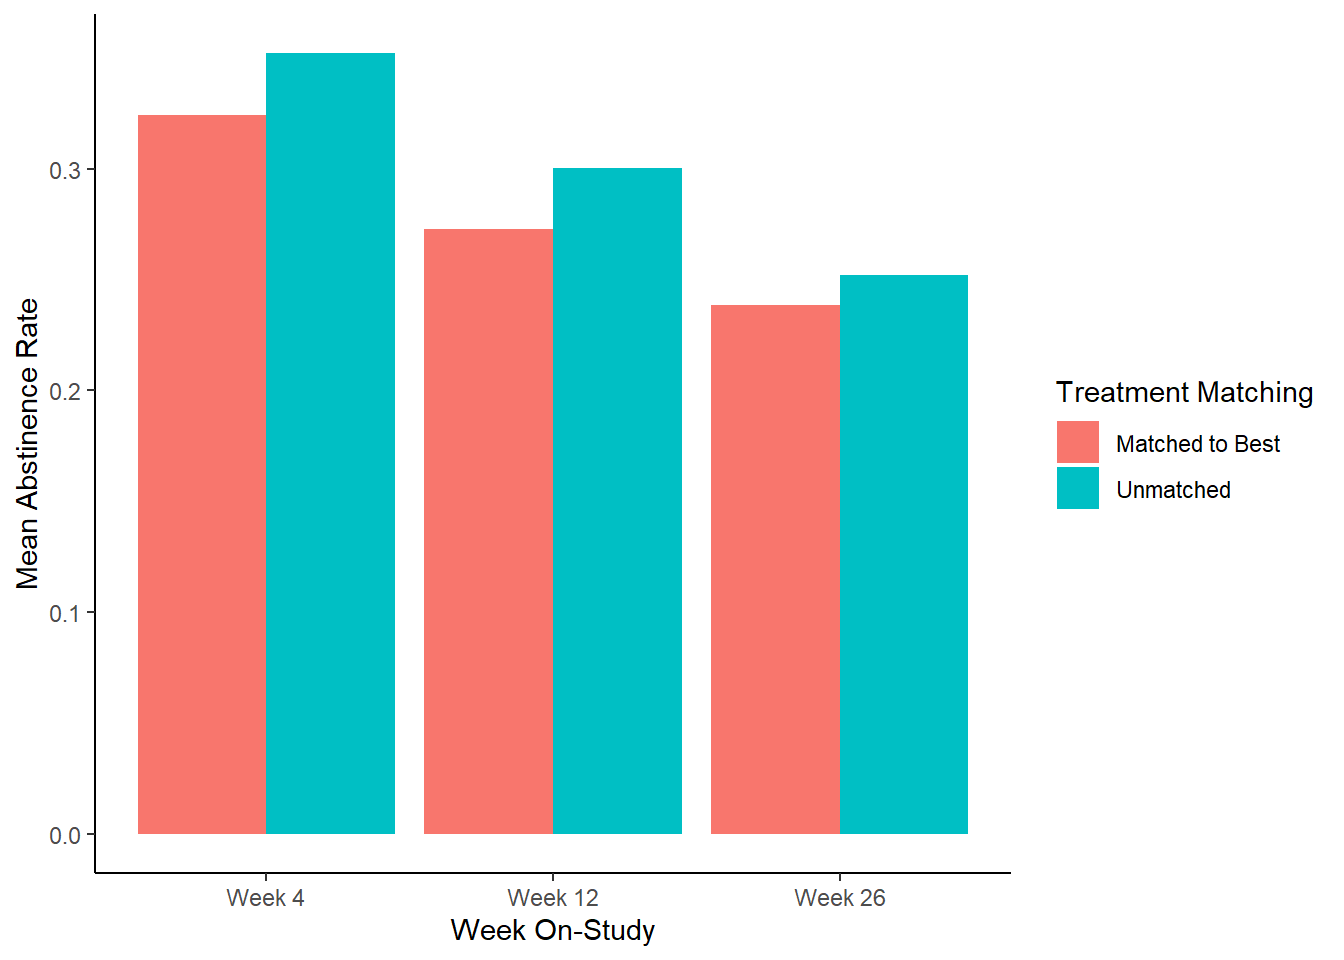

In [ ]:
fig_clin_ben_wk12 <- d |> 
  mutate(week_cat = factor(week,
                           levels = c(4, 12, 26),
                           labels = c("Week 4", "Week 12", "Week 26")),
         tx_match = factor(tx_match, 
                           levels = c(TRUE, FALSE),
                           labels = c("Matched to Best", "Unmatched"))) |> 
  group_by(week_cat, tx_match) |> 
  summarize(mean_outcome = mean(outcome_rct_num)) |> 
  ggplot(aes(x = week_cat, y = mean_outcome, fill = tx_match)) +
  geom_col(position = "dodge") +
  labs(
    x = "Week On-Study",
    y = "Mean Abstinence Rate",
    fill = "Treatment Matching"
  )


Make predicted dataset

In [ ]:
d_fig_alt <- d |> 
  select(subid, c_tx_match, c4_week_log_2) |> 
  mutate(pred_logodds = predict(model_bayes, d)) |> 
  mutate(pred_probs = predict(model_bayes, d, type = "response")) |> 
  mutate(week_cat = factor(c4_week_log_2,
                           levels = c(0, (log(12, base = 2) - 2), 
                                      (log(26, base = 2) - 2)),
                           labels = c("Week 4", "Week 12", "Week 26")),
         tx_match = factor(c_tx_match, 
                           levels = c(0.5, -0.5),
                           labels = c("Matched to Best", "Unmatched"))) |> 
  group_by(week_cat, tx_match) |> 
  summarize(mean_pred_logodds = mean(pred_logodds),
            mean_pred_probs = mean(pred_probs))


`summarise()` has grouped output by 'week_cat'. You can override using the
`.groups` argument.

Log odds figure

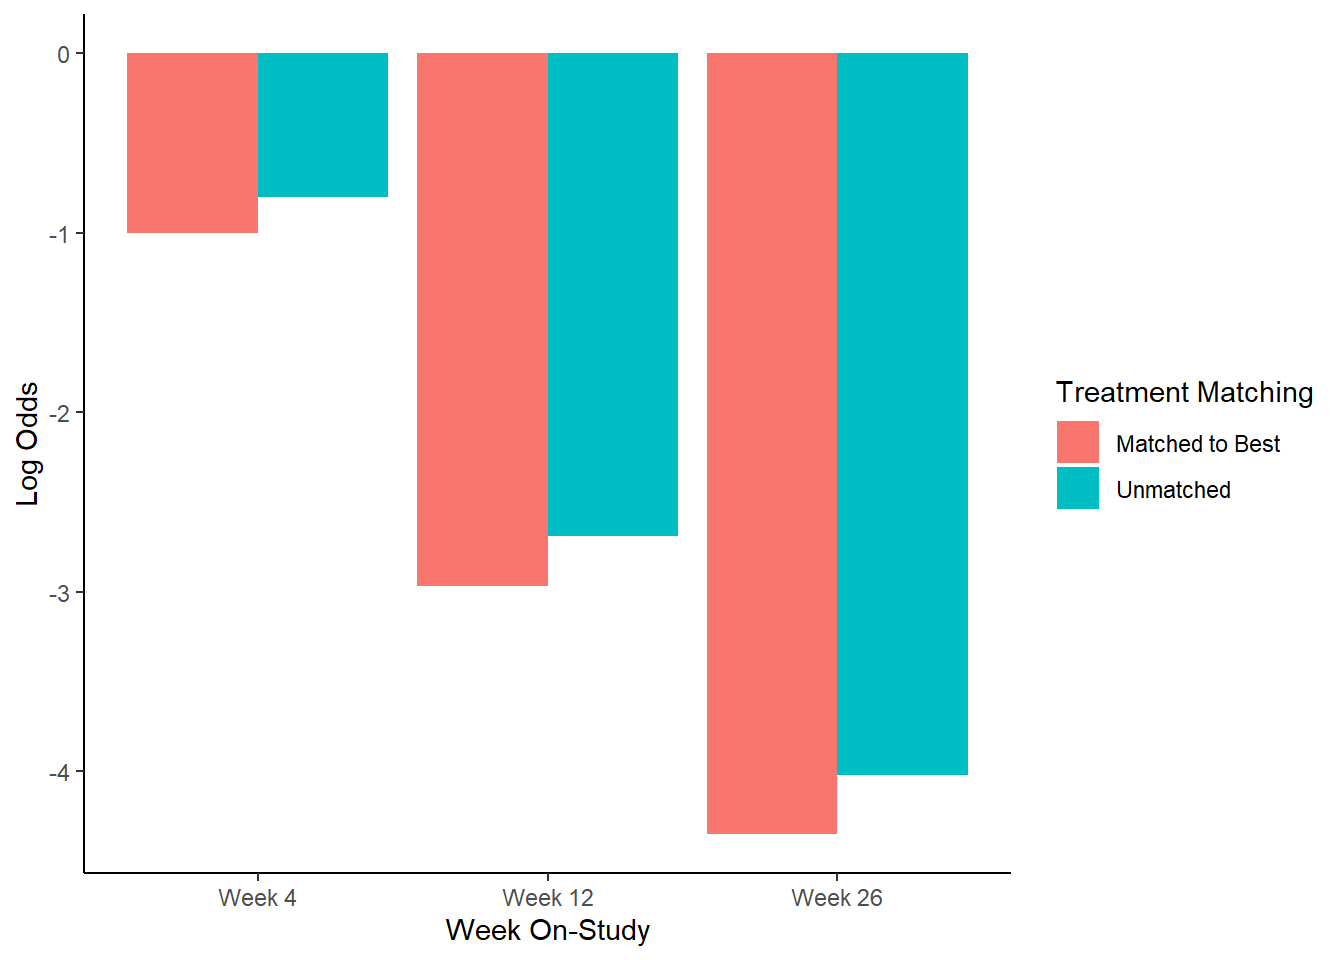

In [ ]:
d_fig_alt |> 
  ggplot(aes(x = week_cat, y = mean_pred_logodds, fill = tx_match)) +
  geom_col(position = "dodge") +
  labs(
    x = "Week On-Study",
    y = "Log Odds",
    fill = "Treatment Matching"
  )


Predicted probabilities figure

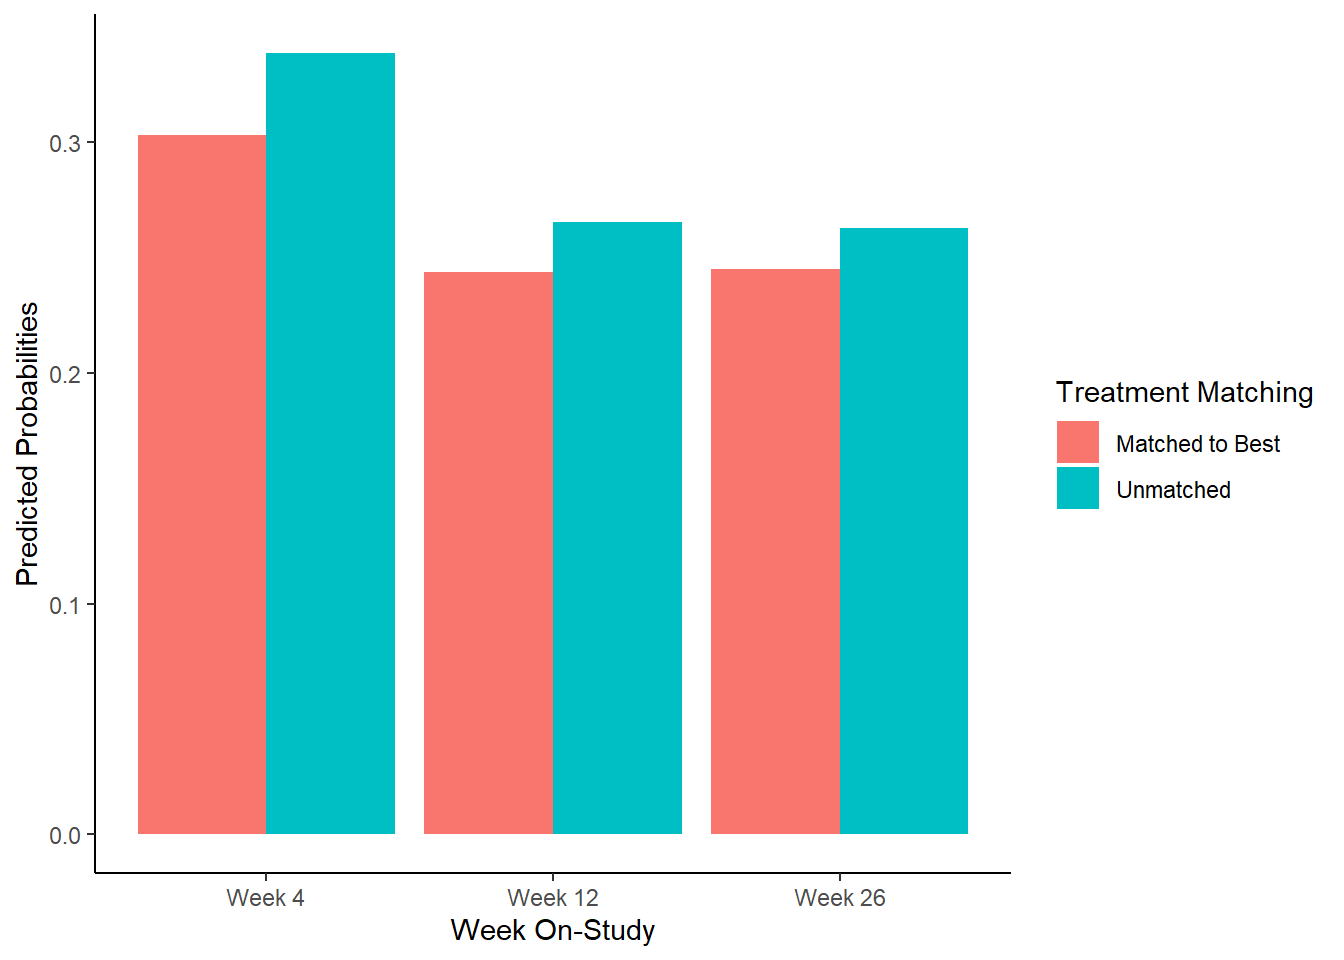

In [ ]:
d_fig_alt |> 
  ggplot(aes(x = week_cat, y = mean_pred_probs, fill = tx_match)) +
  geom_col(position = "dodge") +
  labs(
    x = "Week On-Study",
    y = "Predicted Probabilities",
    fill = "Treatment Matching"
  )
